# Overview: The target variable is distinguishing which class (Benign or Malignant) the cancer belongs to.

## The following is the workflow for devising a model that predicts these well based on the performance metric chosen

1. Data Cleaning, Exploration and Visualization
2. Split the data into train- test
3. Feature Scaling and data treatment
4. Select a performance measure 
5. Finalize the model algorithm using nested CV
6. Fine tune the hyper parameters of the selected algorithm to finalize the model

The data set has been downloaded from Kaggle - https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

Description: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names



__Importing required libraries __

In [1]:
import pandas as pd
import numpy as np 
import sklearn
from  sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV
import warnings; warnings.simplefilter('ignore')
## Plotting Learning Curves

# A learning curve shows the validation and training score of an estimator for varying numbers of training samples. 
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
# If both the validation score and the training score converge to a value that is too low with increasing size of the training set, 
# we will not benefit much from more training data. 

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,scoring_metric = None, scoring_metric_label = "score",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring_metric_label)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring_metric)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_results( grid ,par_1,par_2, title, y_lab):
    """Select two hyperparameters from which we plot the fluctuations"""
    index = 'param_' + par_1
    columns = 'param_' + par_2

    # prepare the results into a pandas.DataFrame
    df = pd.DataFrame(grid.cv_results_)

    # Remove the other by selecting their best values (from gscv.best_params_)
    other = [c for c in df.columns if c[:6] == 'param_']
    other.remove(index)
    other.remove(columns)
    # Create pivot tables for easy plotting
    table_mean = df.pivot_table(index=index, columns=columns,
                                values=['mean_test_score'])
    table_std = df.pivot_table(index=index, columns=columns,
                               values=['std_test_score'])

    # plot the pivot tables
    plt.figure()
    ax = plt.gca()
    for col_mean, col_std in zip(table_mean.columns, table_std.columns):
        table_mean[col_mean].plot(ax=ax, yerr=table_std[col_std], marker='o',
                                  label=col_mean)
    plt.title(title)
    plt.ylabel(y_lab)
    plt.legend(title=table_mean.columns.names)
    plt.show()


#plot_results(index='dar__ordar', columns='dar__ordriv')
#plot_results(index='driver__low_fq', columns='driver__low_fq_width')



Importing the data set

In [3]:
#path = "C:/Users/fazel/Downloads/"
#Please give your own path here
data = pd.read_csv(path + "wdbc.data", header = None)
# Creating a binary variable instead of M/B for the dependent variable
data[1] = data[1].apply(lambda x: 1 if x== 'M' else 0)

### Step 1-Data Cleaning, Exploration and Visualization. The data that has been shared is already cleaned 

In [4]:
data.dtypes
data.shape
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
0     569 non-null int64
1     569 non-null int64
2     569 non-null float64
3     569 non-null float64
4     569 non-null float64
5     569 non-null float64
6     569 non-null float64
7     569 non-null float64
8     569 non-null float64
9     569 non-null float64
10    569 non-null float64
11    569 non-null float64
12    569 non-null float64
13    569 non-null float64
14    569 non-null float64
15    569 non-null float64
16    569 non-null float64
17    569 non-null float64
18    569 non-null float64
19    569 non-null float64
20    569 non-null float64
21    569 non-null float64
22    569 non-null float64
23    569 non-null float64
24    569 non-null float64
25    569 non-null float64
26    569 non-null float64
27    569 non-null float64
28    569 non-null float64
29    569 non-null float64
30    569 non-null float64
31    569 non-null float64
dtypes: float64(30), int64(2)
memor

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [5]:
# Looking at the distribution of the target variable
data[1].value_counts()

0    357
1    212
Name: 1, dtype: int64

### Steps 2 & 3 - Splitting the data into training and testing data sets followed by standardization of the dataset

#### It is to be noted that the standardization has been done in this case because we are using the algorithms KNN and Logistic regression which are sensitive to the degree of the values

In [8]:
df_y = data.iloc[:,1].values
df_x = data.loc[:,2:33].values
x_train,x_test,y_train,y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 123,stratify = df_y)

In [9]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Step 4: Choosing a performance metric
    F score (harmonic mean of precisiona nd recall) is chosen as the performance metric.
    Having high precision or recall cannot be the performance metric as there are drastic 
    consequences based on the prediction made. Hence a combination of both these terms i.e
    F score is considered as a performance metric


In [10]:
# Defining the performance metric
f1_scorer = make_scorer(f1_score, pos_label=1)

### Step 5: Decision Tree, Logistic Regression and KNN are the algorithms considered for this classification problem.
       As the size of the data is very small, using nested CV to evaluate these models 
       doesn't seem the right approach. For this problem, all the 
       algorithms are fine tuned and then the models are compared for 
       each one of them

### Step 5a: Decision Tree 
__Hyper parameters: max_depth & min_samples_leaf are fine tuned to get the best model__

In [11]:
# Decision Tree
depth={"max_depth":[1,5,10,15,20,25,30],
       "min_samples_leaf" : [10,20,30]}       

DTC=DecisionTreeClassifier()

grid_dt=GridSearchCV(DTC,param_grid=depth , cv=4, scoring= f1_scorer)
grid_dt.fit(x_train,y_train) 
dt_result =pd.DataFrame(grid_dt.cv_results_)
grid_dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 10}

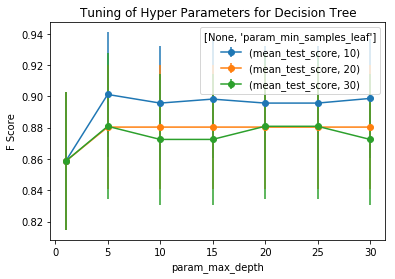

In [12]:
plot_results( grid_dt ,par_1 = "max_depth",par_2 = "min_samples_leaf", title = "Tuning of Hyper Parameters for Decision Tree", y_lab= "F Score")

In [13]:
final_dt = DecisionTreeClassifier(**grid_dt.best_params_)
final_dt.fit(x_train, y_train)
#final_dt.predict(x_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Step 5b: Logistic Regression
__Doesn't have any fine tuning as at this stage regularization hasn't been considered__


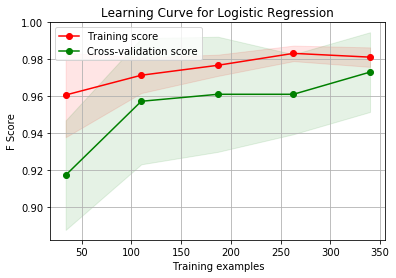

In [14]:
log_model = LogisticRegressionCV(cv = 4)
log_model.fit(x_train, y_train)
log_plot = plot_learning_curve(log_model, "Learning Curve for Logistic Regression", x_train, y_train, ylim=None, cv=4,scoring_metric = f1_scorer, scoring_metric_label = "F Score")
log_plot.show()

#### From the graph, it can be inferred that initially, the model was overfitting due to the high difference in performance between training and validation data sets

### Step 5c: KNN 
__Hyper paramenters tuned are k_neighbors values and weight options __

In [16]:
#KNN
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, cv = 4, scoring = f1_scorer)
grid_knn.fit(x_train,y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, pos_label=1), verbose=0)

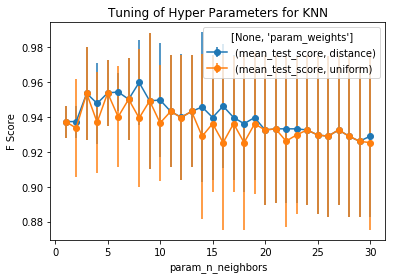

In [17]:
plot_results(grid_knn ,par_1 = "n_neighbors",par_2 = "weights", title = "Tuning of Hyper Parameters for KNN", y_lab= "F Score")


In [18]:
grid_knn.best_params_


{'n_neighbors': 8, 'weights': 'distance'}

In [19]:
final_knn = KNeighborsClassifier(**grid_knn.best_params_)
final_knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance')

### Step 6: Choosing the final model. There are three finalized models from each algorithm - decision tree, logistic regression and KNN
__Final model will be chosen based on the performance on test data set using AUROC (Assuming that data is balance - 0.59 class ratio)__

### 6a : Calculating AUROC for finalized decision tree

In [20]:
y_pred_dt = final_dt.predict(x_test)
roc_auc_score(y_test, y_pred_dt)

0.8978174603174603

### 6b : Calculating AUROC for finalized logistic regression

In [21]:
y_pred_log = log_model.predict(x_test)
roc_auc_score(y_test, y_pred_log)

0.9811507936507938

### 6c : Calculating AUROC for finalized KNN

In [22]:
y_pred_knn = final_knn.predict(x_test)
roc_auc_score(y_test, y_pred_knn)

0.9553571428571429

### Summary - 
__From the above, we can see that all the three models are very similar. Logistic has the highest AUROC.
Since this case has high cost for inaccuracy, additional analysis needs to be done inculcating the cost matrix.__